In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')
price = data.pop('Tile_Price')
data['Tile_Price'] = price 
data.head()

,Tile_Name,Tile_Color,Tile_Size,Room_Type,Room_Color,Tile_type,Finish_Type,Tile_Price
0,Amberese,Rose,300 x 300 mm,Bedroom,Rose,Fully Vitrified Full Body Porcelain,Anti Slip,230
1,Amberese,Red,300 x 300 mm,Bedroom,Red,Fully Vitrified Full Body Porcelain,Anti Slip,237
2,Amberese,Brown,300 x 300 mm,Bedroom,Brown,Fully Vitrified Full Body Porcelain,Anti Slip,237
3,Amberese,Gray,300 x 300 mm,Bedroom,Gray,Fully Vitrified Full Body Porcelain,Anti Slip,155
4,Amberese,Piacentina Muschio Green,300 x 300 mm,Bedroom,Green,Porcelain Tile,Anti Slip,257


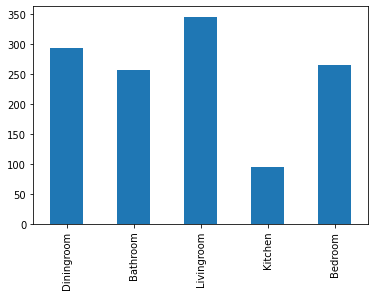

In [ ]:
#Vizualizing categorical data and their counts
data['Room_Type'].value_counts(sort=False).plot(kind='bar')

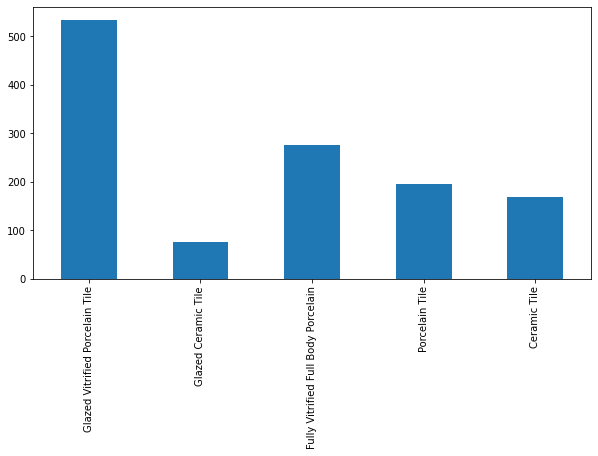

In [ ]:
plt.figure(1, figsize=(10,5))
data['Tile_type'].value_counts(sort=False).plot(kind='bar')

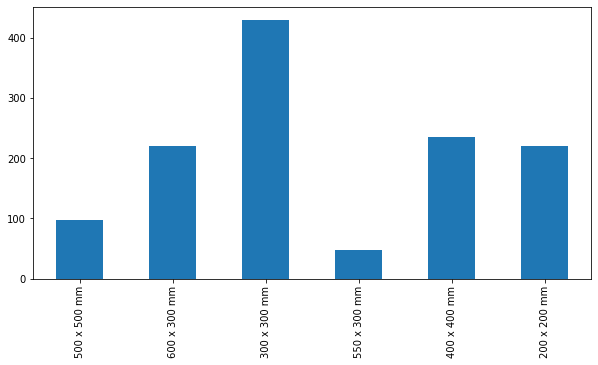

In [ ]:
plt.figure(1, figsize=(10,5))
data['Tile_Size'].value_counts(sort=False).plot(kind='bar')

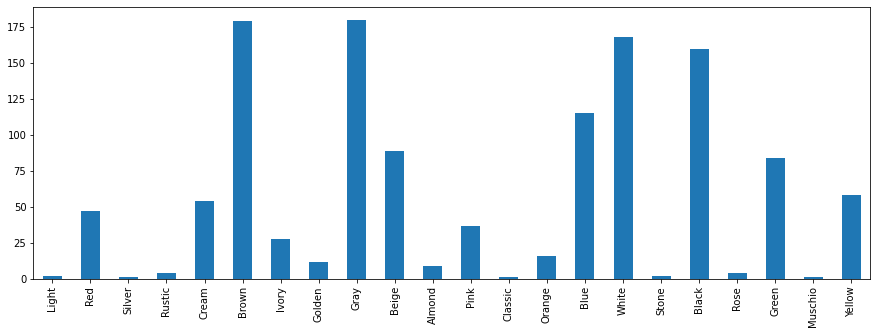

In [ ]:
'''
#This is for replacing less frequent colors(<10) but this did not improve the model accuracy. 
#Decided to keep the colors as it is
g = data.groupby('Room_Color')
col = 'Room_Color'
g.filter(lambda x: len(x) >= 10)
data.loc[data[col].value_counts()[data[col]].values < 10, col] = "Other"
'''
plt.figure(1, figsize=(15,5))
data['Room_Color'].value_counts(sort=False).plot(kind='bar')

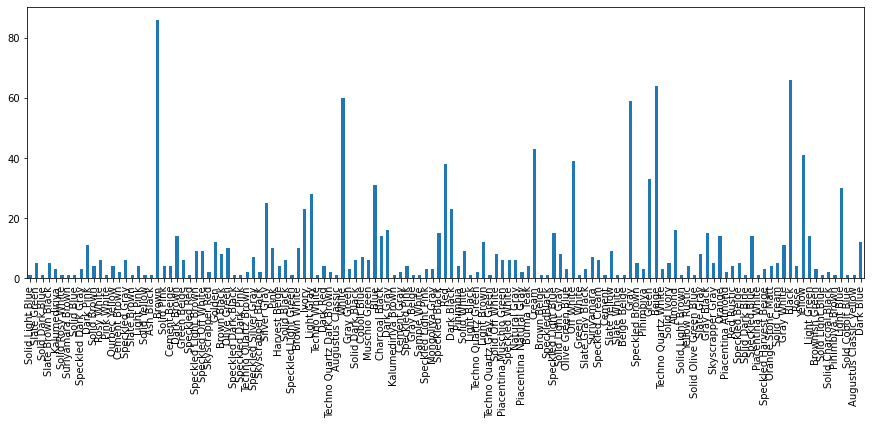

In [ ]:
'''
g = data.groupby('Tile_Color')
col = 'Tile_Color'
g.filter(lambda x: len(x) >= 10)
data.loc[data[col].value_counts()[data[col]].values < 10, col] = "Other"
'''
plt.figure(1, figsize=(15,5))
data['Tile_Color'].value_counts(sort=False).plot(kind='bar')


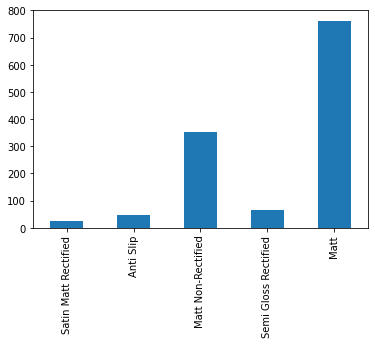

In [ ]:
data['Finish_Type'].value_counts(sort=False).plot(kind='bar')

In [3]:
'''
Categorical data needs to be encoded. 
Ordinal encoding and One-hot encoding used and tested.
Accuracy of the model was higher when using one-hot encoding thus it was used.
'''
fields = data.drop(['Tile_Price'],axis=1).columns #Tile_Price is numerical
uniques = [np.sort(data[i].unique()) for i in fields]

encoders = [OneHotEncoder(handle_unknown='ignore') for i in range(7)]

for i,encoder in enumerate(encoders):
    encoder.fit(np.array(uniques[i]).reshape((-1,1)))

In [4]:
# Tile_Price is normalized (by dividing max value)

max_price = data['Tile_Price'].max()
price_scaled = data['Tile_Price']/max_price

price_normalized = pd.DataFrame(price_scaled,columns=['Tile_Price'])


In [5]:
dataframes = [price_normalized]
for i in range(6):
  encoded = encoders[i+1].transform(np.array(data[fields[i+1]]).reshape((-1,1))).toarray()
  dataframes.append(pd.DataFrame(encoded,columns=[fields[i+1]+j for j in uniques[i+1]]))
  

In [6]:
dataset = pd.concat(dataframes,axis=1)

In [7]:
dataset.head()

,Tile_Price,Tile_ColorAlmond,Tile_ColorAsh Black,Tile_ColorAugustus Classic,Tile_ColorAugustus Classic yellow,Tile_ColorBeige,Tile_ColorBeige Beige,Tile_ColorBlack,Tile_ColorBlue,Tile_ColorBrown,Tile_ColorBrown Beige,Tile_ColorBrown Black,Tile_ColorBrown White,Tile_ColorBrownish Green,Tile_ColorBurma Teak,Tile_ColorCement,Tile_ColorCement Beige,Tile_ColorCement Brown,Tile_ColorCement Gray,Tile_ColorCharcoal Black,Tile_ColorCobolt Blue,Tile_ColorCream,Tile_ColorDark Black,Tile_ColorDark Blue,Tile_ColorDark Brown,Tile_ColorDark Gray,Tile_ColorDark Pink,Tile_ColorDark Red,Tile_ColorGolden,Tile_ColorGray,Tile_ColorGray Beige,Tile_ColorGray Black,Tile_ColorGray Green,Tile_ColorGray White,Tile_ColorGreen,Tile_ColorGreen Beige,Tile_ColorGreen White,Tile_ColorHarvest Beige,Tile_ColorIvory,Tile_ColorKalumediriya,...,Tile_Size500 x 500 mm,Tile_Size550 x 300 mm,Tile_Size600 x 300 mm,Room_TypeBathroom,Room_TypeBedroom,Room_TypeDiningroom,Room_TypeKitchen,Room_TypeLivingroom,Room_ColorAlmond,Room_ColorBeige,Room_ColorBlack,Room_ColorBlue,Room_ColorBrown,Room_ColorClassic,Room_ColorCream,Room_ColorGolden,Room_ColorGray,Room_ColorGreen,Room_ColorIvory,Room_ColorLight,Room_ColorMuschio,Room_ColorOrange,Room_ColorPink,Room_ColorRed,Room_ColorRose,Room_ColorRustic,Room_ColorSilver,Room_ColorStone,Room_ColorWhite,Room_ColorYellow,Tile_typeCeramic Tile,Tile_typeFully Vitrified Full Body Porcelain,Tile_typeGlazed Ceramic Tile,Tile_typeGlazed Vitrified Porcelain Tile,Tile_typePorcelain Tile,Finish_TypeAnti Slip,Finish_TypeMatt,Finish_TypeMatt Non-Rectified,Finish_TypeSatin Matt Rectified,Finish_TypeSemi Gloss Rectified
0,0.215760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.222326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.222326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.145403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.241088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# One-hot encoding labels
labels = data['Tile_Name']
encoded = encoders[0].transform(np.array(labels).reshape((-1,1))).toarray()
labels = pd.DataFrame(encoded,columns=[j for j in uniques[0]])
print(encoded.shape)

(1251, 32)


In [9]:
train_in, test_in, train_out, test_out =  train_test_split(dataset,labels, test_size=0.25)

In [10]:
train_in.shape

(938, 175)

In [11]:
model=tf.keras.Sequential([
  tf.keras.layers.Input(shape=(175,)),
  tf.keras.layers.Dense(250,activation='relu',kernel_regularizer='l2'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(125,activation='relu',kernel_regularizer='l2'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(40,activation='relu'),
  tf.keras.layers.Dropout(0.2), 
  
  tf.keras.layers.Dense(40,activation='relu'),
  tf.keras.layers.Dropout(0.2), 
  tf.keras.layers.Dense(32,activation='sigmoid')
  ])
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               44000     
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               31375     
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1

In [13]:
history = model.fit(train_in,train_out, batch_size=32 ,epochs=200,validation_data=(test_in,test_out))

Epoch 1/200
30/30 [==============================] - 2s 28ms/step - loss: 6.6840 - accuracy: 0.0772 - val_loss: 5.2755 - val_accuracy: 0.1534
Epoch 2/200
30/30 [==============================] - 0s 5ms/step - loss: 4.8376 - accuracy: 0.1837 - val_loss: 4.0148 - val_accuracy: 0.1534
Epoch 3/200
30/30 [==============================] - 0s 5ms/step - loss: 3.7868 - accuracy: 0.1849 - val_loss: 3.3892 - val_accuracy: 0.1565
Epoch 4/200
30/30 [==============================] - 0s 5ms/step - loss: 3.2464 - accuracy: 0.1773 - val_loss: 3.0000 - val_accuracy: 0.2716
Epoch 5/200
30/30 [==============================] - 0s 5ms/step - loss: 2.9078 - accuracy: 0.2084 - val_loss: 2.7942 - val_accuracy: 0.3099
Epoch 6/200
30/30 [==============================] - 0s 5ms/step - loss: 2.6964 - accuracy: 0.2832 - val_loss: 2.6341 - val_accuracy: 0.2971
Epoch 7/200
30/30 [==============================] - 0s 5ms/step - loss: 2.6077 - accuracy: 0.2930 - val_loss: 2.5456 - val_accuracy: 0.3259
Epoch 8/200


In [14]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
xc=range(200)


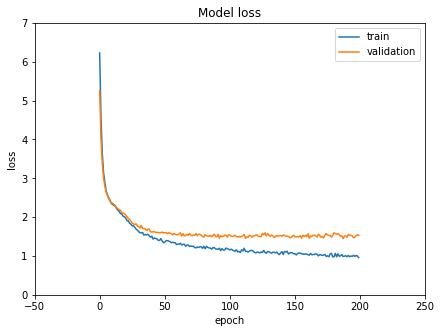

In [15]:

#Visualizing losses
plt.figure(1, figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.style.use(['classic'])

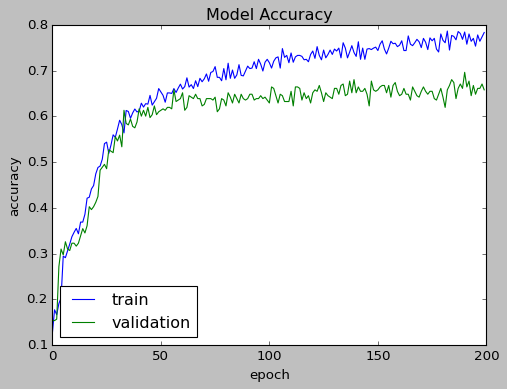

In [16]:
#Visualizing accuracies
plt.figure(2, figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc=3)
plt.style.use(['classic'])

In [61]:
#test 
x = np.array(['237','Red',	'300 x 300 mm',	'Bedroom',	'Red','Fully Vitrified Full Body Porcelain','Anti Slip']).reshape((-1,1))

In [62]:
test = [int(x[0])/max_price]
for i in range(1,7): #Encoding the test input same as model input
  encoded = encoders[i].transform(np.array(x[i]).reshape((-1,1))).toarray().flatten()
  test.extend(encoded)
test = np.array(test).reshape((1,175))


In [65]:
res = model.predict(test) #predict

In [67]:
uniques[0][np.argsort(res.flatten())[-1:-5:-1]] #select the predicted names from tile name list

array(['Amberese', 'Glazed', 'Wild', 'Australian Stone'], dtype=object)

In [ ]:
model.save('trained_model.h5') #Save model

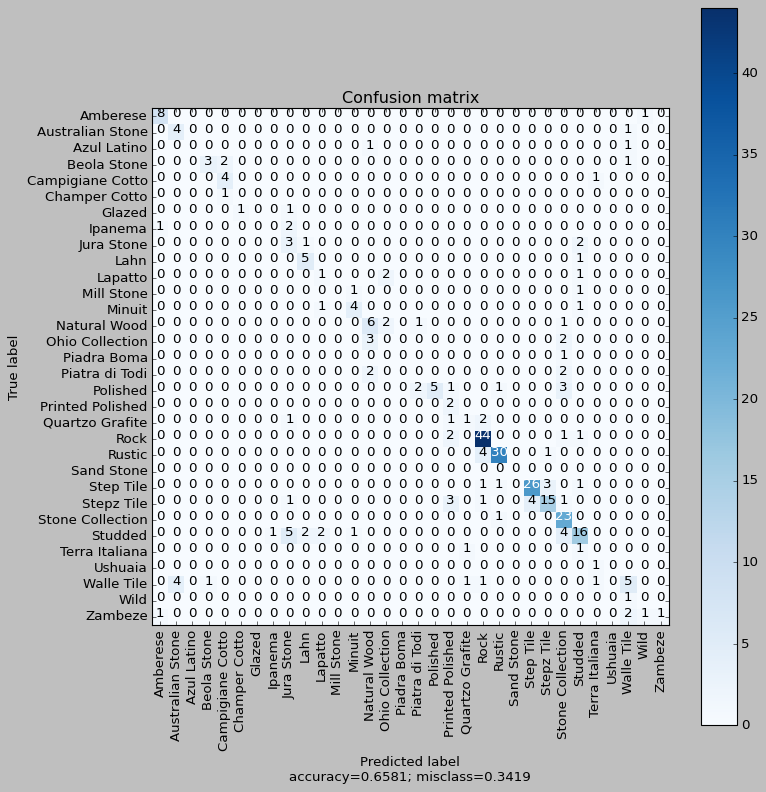

In [78]:
from sklearn.metrics import confusion_matrix
import itertools

pred = model.predict_classes(test_in, batch_size=128, verbose=0)
test_labels = uniques[0][np.argsort(test_out.to_numpy(), axis=1)[:,-1]]
cm = confusion_matrix(test_labels,pred,labels=np.sort(data['Tile_Name'].unique()))

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

cmap = plt.get_cmap('Blues')

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Confusion matrix")
plt.colorbar()


tick_marks = np.arange(len(uniques[0]))
plt.xticks(tick_marks, uniques[0], rotation=90)
plt.yticks(tick_marks, uniques[0])


thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.show()